In [115]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from sympy import diff,solve
from itertools import count
import math

from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

import math
import matplotlib.patches as patches
import pylab

In [258]:
class three_phase:
    """
    Represents...
    """
    
    def __init__(self,g_α,g_β,g_L,phases,A=0):
        self.g_α = g_α
        self.g_β = g_β
        self.g_L = g_L
        self.A = A
        self.phases = phases

    def beta_L(self):
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')

        g_α, g_β, g_L, A = self.g_α, self.g_β, self.g_L, self.A 
        
        eq1 = (-diff(g_L) + diff(g_β))
        eq2 = (-diff(g_β) + (g_β - g_L)/(x_β - x_L))
        sol = solve((eq1,eq2),[x_β,x_L])

        if 0 <= sol[0][0] <= 1:
            x_β_,x_L_ = sol[0][0],sol[0][1]
        else:
            x_β_,x_L_ = sol[1][0],sol[1][1]
        z_β_ = (X - x_L_)/(x_β_ - x_L_)
        z_L_ = 1 - z_β_
        return z_β_*g_β.subs(x_β, x_β_) + z_L_*g_L.subs(x_L, x_L_)
    
    
    def alpha_L(self):
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        g_α, g_β, g_L, A = self.g_α, self.g_β, self.g_L, self.A
        
        eq1 = (-diff(g_L) + diff(g_α))
        eq2 = (-diff(g_α) + (g_α - g_L)/(x_α - x_L))
        sol = solve((eq1,eq2),[x_α,x_L])
        if 0 <= sol[0][0] <= 1:
            x_α_,x_L_ = sol[0][0],sol[0][1]
        else:
            x_α_,x_L_ = sol[1][0],sol[1][1]
        x_α_,x_L_ = sol[0][0],sol[0][1]
        z_α_ = (X - x_L_)/(x_α_ - x_L_)
        z_L_ = 1 - z_α_
        return z_α_*g_α.subs(x_α, x_α_) + z_L_*g_L.subs(x_L, x_L_)
    
    def alpha_beta(self):
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        
        g_α, g_β, g_L, A = self.g_α, self.g_β, self.g_L, self.A
        
        eq1 = (-diff(g_α) + diff(g_β))
        eq2 = (-diff(g_β) + (g_β - g_α + A*(1-2*(x_α-X)/(x_α-x_β)))/(x_β - x_α))
        sol = solve((eq1,eq2),[x_α,x_β])

        x_α_,x_β_ = sol[0][0],sol[0][1]
        z_α_ = (X - x_β_)/(x_α_ - x_β_)
        z_β_ = 1 - z_α_
        return z_α_*g_α.subs(x_α,x_α_) + z_β_*g_β.subs(x_β,x_β_) + A*z_α_*z_β_ 
    
    def alpha_beta_L(self): 
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')

        g_α, g_β, g_L, A = self.g_α, self.g_β, self.g_L, self.A
        
        eq1 = (-diff(g_α) + diff(g_β))
        eq2 = (-diff(g_β) + diff(g_L))
        eq3 = (-diff(g_L) + (g_α - g_L + A*z_β)/(x_α - x_L))
        eq4 = (-diff(g_L) + (g_β - g_L + A*z_α)/(x_β - x_L))
        eq5 = (X - ((1-z_α-z_β)*x_L + z_α*x_α + z_β*x_β))
        sol = solve((eq1,eq2,eq3,eq4,eq5),[x_α,x_β,x_L,z_α,z_β])

        if np.size(sol) == 0:
            return float('inf')
        else:
            x_α_,x_β_,x_L_ = sol[0][0],sol[0][1],sol[0][2]
            z_α_,z_β_ = sol[0][3],sol[0][4]
            z_L_ = 1-z_α_-z_β_
        return z_α_*g_α.subs(x_α,x_α_) + z_β_*g_β.subs(x_β,x_β_) + z_L_*g_L.subs(x_L,x_L_) + A*z_α_*z_β_

#input the common tangent and 2 free energy functions
#returns the feasible boundaries    
    def inter_tan_G(self,com_tan,g_1,g_2,x_1,x_2):
        X = sy.symbols('X')
        
        eq1 = (com_tan - g_1.subs(x_1,X))
        sol_1 = solve((eq1),[X])
        eq2 = (com_tan - g_2.subs(x_2,X))
        sol_2 = solve((eq2),[X])
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])

#Create new common tangents that obey the feasible boundaries
# and are infinity elsewhere
    def correct_tangent(self,com_tan,intersection_G):
        X = sy.symbols('X')
        
        new_tangent = sy.Piecewise(
            (float('inf'),X <= min(intersection_G) -1e-8), #account for some error
            (float('inf'),X >= max(intersection_G)+1e-8),
            (com_tan,True))
        return new_tangent
    
#Find the boundaries which the common tangents intersect
    def intersect_com_tans(self,com_tan_1,com_tan_2):
        X = sy.symbols('X')

        eq1 = (com_tan_1 - com_tan_2)
        sol = np.array(solve((eq1),[X]))
        return sol[np.where((sol > 0)&(sol < 1))]

    def intersect_abl(self,com_abl,com_al,com_bl): 
        X = sy.symbols('X')

        eq1 = (com_abl - com_al)
        sol_1 = solve((eq1),[X])
        if np.size(sol_1) == 0:
            sol_1 = [float('inf')]
        eq2 = (com_abl - com_bl)
        sol_2 = solve((eq2),[X])
        if np.size(sol_2) == 0:
            sol_2 = [float('inf')]
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])
    
    def correct_tangent_abl(self,com_tan,intersect_abl,al_G,bl_G):
        X = sy.symbols('X')

        if min(al_G) <= intersect_abl[0] <= max(al_G):
            new_tangent = sy.Piecewise(
                (float('inf'),X <= min(intersect_abl) -1e-8), #account for some error
                (float('inf'),X >= max(intersect_abl)+1e-8),
                (com_tan,True))
        else:
            new_tangent = sy.Piecewise(
                (float('inf'),X <= 1 ), #account for some error
                (float('inf'),X >= 0))
        return new_tangent
    
    ##Find all of the points where a common tangent touches free energies and crosses other common tangents
    def important_points(self):
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        alpha_L,beta_L,alpha_beta,alpha_beta_L = self.alpha_L(),self.beta_L(),self.alpha_beta(),self.alpha_beta_L()
        g_α, g_β, g_L, A = self.g_α, self.g_β, self.g_L, self.A
        al_G = self.inter_tan_G(alpha_L,g_α,g_L,x_α,x_L)
        bl_G = self.inter_tan_G(beta_L,g_β,g_L,x_β,x_L)
        ab_G = self.inter_tan_G(alpha_beta,g_α,g_β,x_α,x_β)
        com_bl = self.correct_tangent(beta_L,bl_G)
        com_al = self.correct_tangent(alpha_L,al_G)
        com_ab = self.correct_tangent(alpha_beta,ab_G)
        al_bl = self.intersect_com_tans(com_al,com_bl)
        al_ab = self.intersect_com_tans(com_al,com_ab)
        ab_bl = self.intersect_com_tans(com_ab,com_bl)
        #Handle the three phase last
        #First finds the intersections
        abl_al_bl = self.intersect_abl(alpha_beta_L,alpha_L,beta_L)
        # computes the common tangent in feasible region 
        com_abl = self.correct_tangent_abl(alpha_beta_L,abl_al_bl,al_G,bl_G)
        # #add end points to full grid
        ends = np.array([0,1])
        grid_start = np.sort(np.concatenate((al_G,bl_G,ab_G,al_bl,al_ab,ab_bl,abl_al_bl)))
        grid_start = grid_start[np.where((0 < grid_start)&(1 > grid_start))]
        #create full grid to look (1e-# is to account for the minor errors and equal values at a point)
        grid_x = np.sort(np.concatenate((grid_start,grid_start*(1-1e-6),grid_start*(1+1e-6),ends)))
        self.grid_x = grid_x
        self.al_tangent = sy.lambdify(X,com_al)
        self.bl_tangent = sy.lambdify(X,com_bl)
        self.ab_tangent = sy.lambdify(X,com_ab)
        self.abl_tangent = sy.lambdify(X,com_abl) 
        
        return grid_x, self.al_tangent, self.bl_tangent, self.ab_tangent, self.abl_tangent
    
    def plot_specific_temp(self,Temp,x_lim = [0,0], y_lim = [0,0]):
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        g_α, g_β, g_L = self.g_α, self.g_β, self.g_L
        self.g_α, self.g_β, self.g_L = self.g_α.subs(T,Temp), self.g_β.subs(T,Temp), self.g_L.subs(T,Temp)
        self.important_points()
        x_grid = np.linspace(0,1,100)
        plt.plot(x_grid, sy.lambdify(x_α,self.g_α)(x_grid),label = 'α')
        plt.plot(x_grid, sy.lambdify(x_β,self.g_β)(x_grid), label = 'β')
        plt.plot(x_grid, sy.lambdify(x_L,self.g_L)(x_grid), label = 'L')
        plt.plot(x_grid, self.al_tangent(x_grid), label = 'αL')
        plt.plot(x_grid, self.ab_tangent(x_grid), label = 'αβ')
        plt.plot(x_grid, self.bl_tangent(x_grid), label = 'βL')
        plt.plot(x_grid, self.abl_tangent(x_grid), label = 'αβL')
        plt.title('Temp = ' + str(Temp) + ',A =' + str(self.A) )
        plt.xlabel('B Fraction')
        plt.ylabel('Gibbs Free energy')
        if x_lim[0] != x_lim[1]:
            plt.xlim(x_lim)
        if x_lim[0] != x_lim[1]:
            plt.ylim(y_lim)
        plt.legend()
        plt.show()
        self.g_α, self.g_β, self.g_L = g_α, g_β, g_L 

        ##Takes in the points and checks the phases of each point
    def check_phase(self):
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        g_α, g_β, g_L, A = self.g_α, self.g_β, self.g_L, self.A
        exit = []
        self.important_points()
        G_L = sy.lambdify(x_L,g_L)
        G_a = sy.lambdify(x_α,g_α)
        G_b = sy.lambdify(x_β,g_β)
        
        for i,val in enumerate(self.grid_x):
            L = G_L(val)
            a = G_a(val)
            b = G_b(val)
            al = self.al_tangent(val)
            bl = self.bl_tangent(val)
            ab = self.ab_tangent(val)
            abl = self.abl_tangent(val)
            check = np.array([al,bl,ab,abl,a,b,L])
            index = np.argmin(check)
            exit.append(self.phases[index])
        exit = np.array(exit)

        exit = exit[self.grid_x>=0]    
        self.grid_x = self.grid_x[self.grid_x>=0] 

        res = {}
        for ph in self.phases: 
            idx = exit == ph
            if idx.any():
                res[ph] = {'c':[np.min(self.grid_x[idx]),np.max(self.grid_x[idx])]}
        
        return res
    
    def full_grid(self,Temp_grid):
        full_phases = []
        for t in Temp_grid:
            g_L = self.g_L
            self.g_L = g_L.subs(T,t)
            full_phases.append(self.check_phase())
            self.g_L = g_L
        return full_phases
        

    ## Take input from full_grid and place into here with correct phases
    def organize_phases(self,Temp_grid):
        grid = self.full_grid(Temp_grid)
        pd = {}
        patches = []
        for ph in self.phases: 
            pd[ph] = []
            for ii,res in enumerate(grid): 
                if ph in res.keys():
                    pd[ph].append([res[ph]['c'][0],Temp_grid[ii]])
                    pd[ph].append([res[ph]['c'][1],Temp_grid[ii]])
        return pd
    

    ##points in the form of the output from organize_phases
    def plot_diagram(self,Temp_grid,title = 'Phase plot',xlabel = 'B Fraction',ylabel = 'Temp'):
        points = self.organize_phases(Temp_grid)
        for ph in self.phases: 
            pp = points[ph]
            if len(pp) > 0:
                cent=(sum([p[0] for p in pp])/len(pp),sum([p[1] for p in pp])/len(pp))
                # sort by polar angle
                pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
                # plot points
                pylab.scatter([p[0] for p in pp],[p[1] for p in pp],label = str(ph))
                # plot polyline
                pylab.gca().add_patch(patches.Polygon(pp,closed=True,fill=False)) 
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
#         plt.savefig(title)
        plt.show()

In [259]:
three_phase(g_α,g_β,g_L,1,phases).__dict__

{'g_α': 40*(x_α - 0.2)**2 + 10,
 'g_β': 40*(x_β - 0.8)**2 + 11,
 'g_L': -T + 40*(x_L - 0.5)**2 + 12,
 'A': array(['αL', 'βL', 'αβ', 'αβL', 'α', 'β', 'L'], dtype='<U3'),
 'phases': 1}

In [261]:
hello = three_phase(g_α,g_β,g_L,phases,A=1)

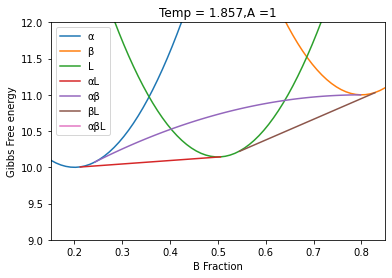

In [262]:
hello.plot_specific_temp(1.857,x_lim = [.15,.85],y_lim = [9,12])

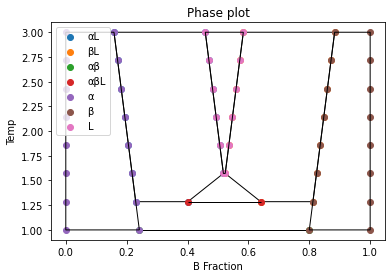

In [263]:
hello.plot_diagram(np.linspace(1,3,8))

In [226]:
x_a, x_b, x_L,T = sy.symbols('x_α, x_β, x_L,T')
phases = np.array(['αL','βL','αβ','αβL','α','β','L'])


x_a0,x_L0,x_b0 = .2,.5,.8
b_a,b_L,b_b = 10,12,11
a = 40

g_α = a*(x_a-x_a0)**2 + b_a
g_β = a*(x_b-x_b0)**2 + b_b
g_L = a*(x_L-x_L0)**2 + b_L - T

In [135]:
sy.lambdify(T,g_L)(5)

40*(x_L - 0.5)**2 + 7

In [136]:
g_L.subs(T,5)

40*(x_L - 0.5)**2 + 7